# 002_Modelling

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost
import shap
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import pickle

from collections import Counter
from numpy import unique
from numpy import mean
from numpy import std
from pandas import read_pickle
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from category_encoders.woe import WOEEncoder
from imblearn.over_sampling import SMOTENC

# Pipeline
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm
# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

# print the JS visualization code to the notebook
shap.initjs()

In [38]:
processed = pd.read_csv("../data/preprocessed/processed_train.csv")

In [39]:
processed.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,family members under 18,country of birth father,country of birth mother,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High School,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,Not in universe,United-States,United-States,US Native,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Higher,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Not in universe,United-States,United-States,US Native,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,School,0,High school,Never married,Not in universe or children,Not in universe,...,Not in universe,Vietnam,Vietnam,Non-US Native,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,School,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,US Native,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,School,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,US Native,0,Not in universe,0,0,94,0


In [40]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

df1 = processed.copy()
df1 = df1.apply(LabelEncoder().fit_transform)
df1.head()


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,family members under 18,country of birth father,country of birth mother,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,3,0,0,2,0,2,3,14,6,...,4,39,39,1,0,1,2,0,1,0
1,58,6,4,34,3,0,2,0,4,8,...,4,39,39,1,0,1,2,52,0,0
2,18,3,0,0,5,0,1,1,14,6,...,4,40,40,0,0,1,2,0,1,0
3,9,3,0,0,5,0,2,1,14,6,...,0,39,39,1,0,1,0,0,0,0
4,10,3,0,0,5,0,2,1,14,6,...,0,39,39,1,0,1,0,0,0,0


### Dummy Classifier

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#establishing random_state for reproducibility
clf_dummy = DummyClassifier(random_state=42) 

X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf_dummy.fit(X_train, y_train)

print(clf_dummy.score(X_train, y_train))

y_pred = clf_dummy.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['O', '1']))

0.9195549920242136
              precision    recall  f1-score   support

           O       0.92      1.00      0.96     28076
           1       0.00      0.00      0.00      2486

    accuracy                           0.92     30562
   macro avg       0.46      0.50      0.48     30562
weighted avg       0.84      0.92      0.88     30562



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Model Selection

In [12]:
# Config
from sklearn import set_config
set_config(display='diagram')

# Evaluate model
def evaluate_model(X, y, model):
    """
    *Reference sklearn.metrics.SCORERS.keys() for list of available scorers*
    """
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=143)
    # Evaluate model
    scores = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=4)
    return scores

# Models dictionary
def get_models():
    models_dict = {
        'Dummy': DummyClassifier(strategy='uniform'),
        'LogReg': LogisticRegression(max_iter=10000, n_jobs=-1),
        'XGB': XGBClassifier(n_estimators=1000),
        'KNN': KNeighborsClassifier(n_jobs=-1)
    }
    
    return models_dict

In [13]:
X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [14]:
# Define models
models = get_models()

# Evaluate models
results = {}

for k, v in models.items():
    # Build pipeline
    clf = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('classifier', v)
    ])
    
    # Evaluate model
    scores = evaluate_model(X_train, y_train, clf)
    results[k] = scores
    name = k
    print(f"{name}\n{'-' * len(name)}")
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
    print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
    print('Mean Recall: %.3f (%.3f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
    print('Test Precision: %.3f (%.3f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
    print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

Dummy
-----
Mean Accuracy: 0.500 (0.004)
Mean F1: 0.138 (0.004)
Mean Recall: 0.498 (0.015)
Test Precision: 0.080 (0.002)
Mean ROC-AUC: 0.500 (0.000)

LogReg
------
Mean Accuracy: 0.929 (0.001)
Mean F1: 0.359 (0.016)
Mean Recall: 0.246 (0.013)
Test Precision: 0.665 (0.022)
Mean ROC-AUC: 0.879 (0.005)

XGB
---
Mean Accuracy: 0.940 (0.002)
Mean F1: 0.556 (0.015)
Mean Recall: 0.471 (0.018)
Test Precision: 0.680 (0.013)
Mean ROC-AUC: 0.921 (0.004)

KNN
---
Mean Accuracy: 0.929 (0.002)
Mean F1: 0.463 (0.020)
Mean Recall: 0.381 (0.020)
Test Precision: 0.590 (0.022)
Mean ROC-AUC: 0.829 (0.007)



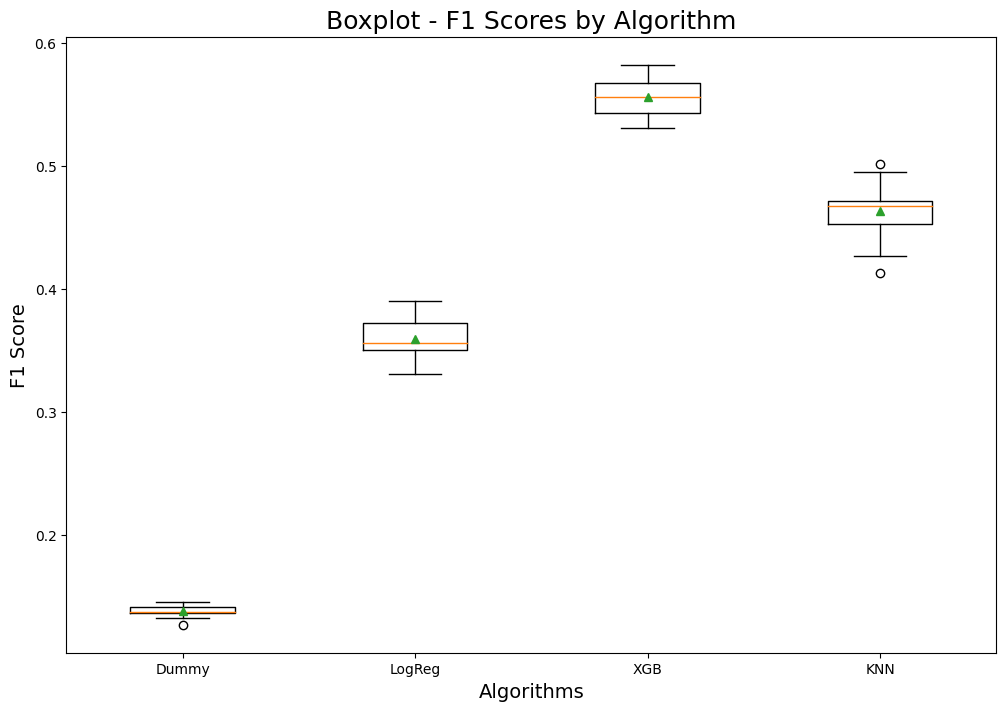

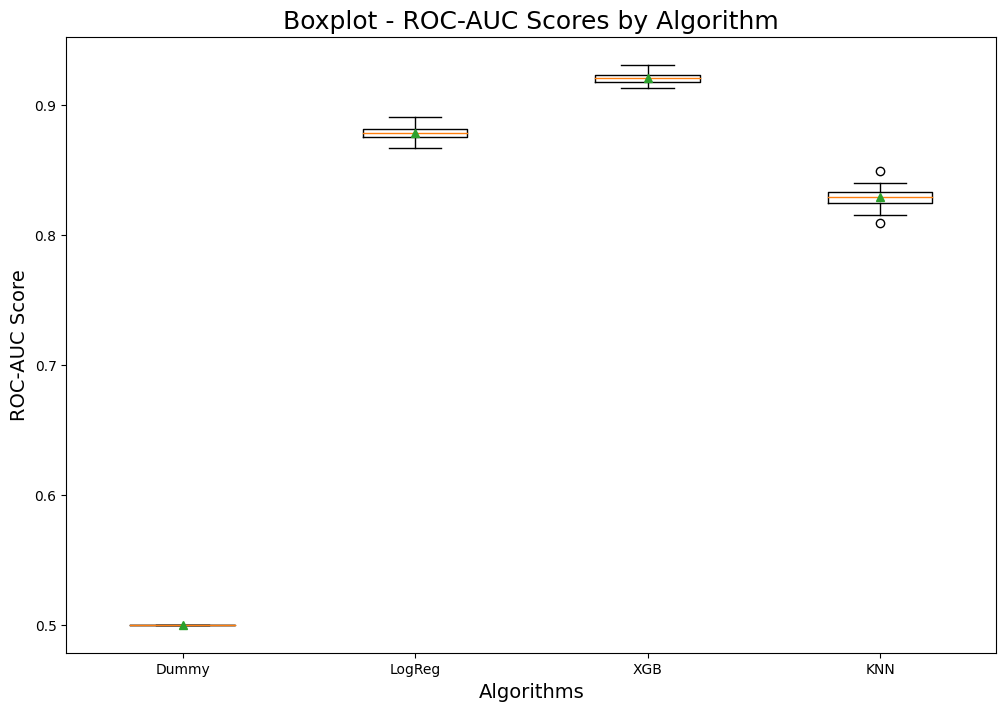

In [15]:
# Prepare plot inputs
names = []
f1 = []
roc_auc = []

for k, v in results.items():
    names.append(k)
    f1.append(v['test_f1'])
    roc_auc.append(v['test_roc_auc'])
    
# F1 scores    
fig = plt.figure(figsize=(12, 8))
plt.boxplot(f1, labels=names, showmeans=True)
plt.title("Boxplot - F1 Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
print("")
plt.show();

# ROC-AUC scores
fig = plt.figure(figsize=(12, 8))
plt.boxplot(roc_auc, labels=names, showmeans=True)
plt.title("Boxplot - ROC-AUC Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("ROC-AUC Score", fontsize=14)
print("" * 2)
plt.show();

XGBoost Appears to be the performant algorithm.

## SMOTE

Now assess if using SMOTE to balance datasets improves performance...

In [16]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [17]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 140487, 1: 12320})


In [18]:
sm = SMOTE(random_state=42)

In [19]:
X_res, y_res = sm.fit_resample(X, y)

In [20]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 140487, 1: 140487})


In [21]:
X_res

,age,class of worker,education,marital stat,major industry code,major occupation code,race,sex,capital gains,capital losses,dividends from stocks,citizenship,own business or self employed,weeks worked in year,wage per hour
0,73,3,2,3,14,6,4,0,0,0,0,1,0,0,0
1,58,6,3,0,4,8,4,1,0,0,0,1,0,52,0
2,18,3,5,1,14,6,1,0,0,0,0,0,0,0,0
3,9,3,5,1,14,6,4,0,0,0,0,1,0,0,0
4,10,3,5,1,14,6,4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280969,54,4,1,4,14,11,4,1,0,54,151,1,0,52,0
280970,38,1,6,2,9,10,1,0,0,0,0,0,1,52,1075
280971,51,1,1,1,4,9,4,0,117,0,0,1,0,40,0
280972,43,1,1,1,18,10,4,1,0,0,1181,1,0,52,0


In [22]:
# Define models
models = get_models()

# Evaluate models
results = {}

for k, v in models.items():
    # Build pipeline
    clf = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('classifier', v)
    ])
    
    # Evaluate model
    scores = evaluate_model(X_res, y_res, clf)
    results[k] = scores
    name = k
    print(f"{name}\n{'-' * len(name)}")
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
    print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
    print('Mean Recall: %.3f (%.3f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
    print('Test Precision: %.3f (%.3f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
    print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

Dummy
-----
Mean Accuracy: 0.500 (0.003)
Mean F1: 0.500 (0.003)
Mean Recall: 0.500 (0.004)
Test Precision: 0.500 (0.003)
Mean ROC-AUC: 0.500 (0.000)



A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


LogReg
------
Mean Accuracy: 0.786 (0.002)
Mean F1: 0.794 (0.002)
Mean Recall: 0.826 (0.003)
Test Precision: 0.764 (0.003)
Mean ROC-AUC: 0.871 (0.002)

XGB
---
Mean Accuracy: 0.929 (0.002)
Mean F1: 0.930 (0.002)
Mean Recall: 0.942 (0.002)
Test Precision: 0.917 (0.002)
Mean ROC-AUC: 0.980 (0.001)

KNN
---
Mean Accuracy: 0.904 (0.002)
Mean F1: 0.907 (0.002)
Mean Recall: 0.937 (0.002)
Test Precision: 0.879 (0.003)
Mean ROC-AUC: 0.955 (0.001)



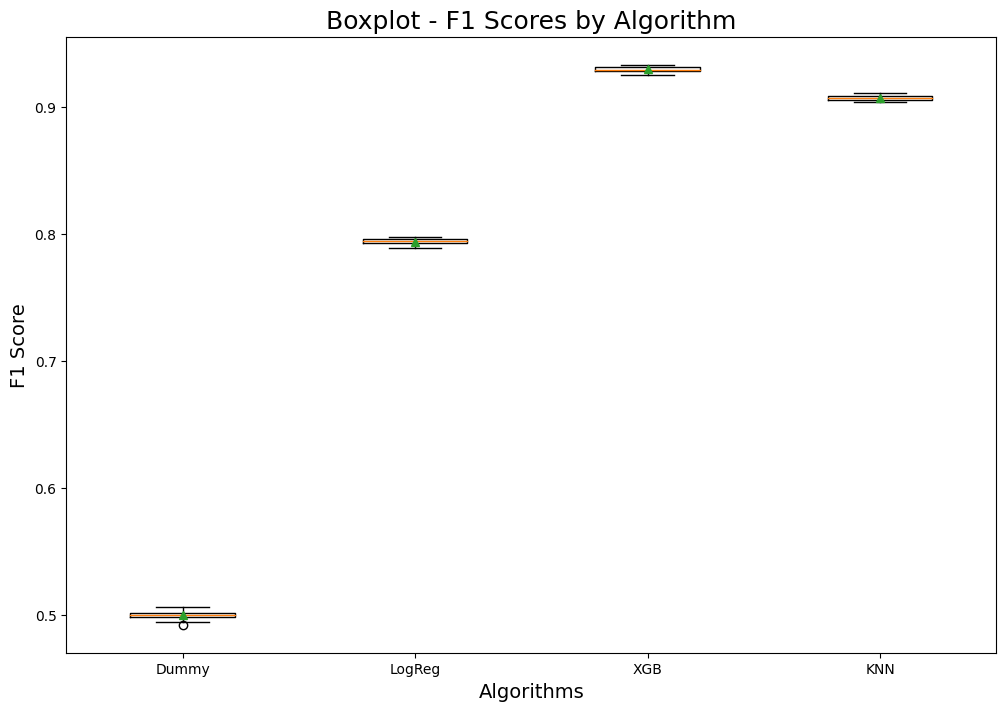

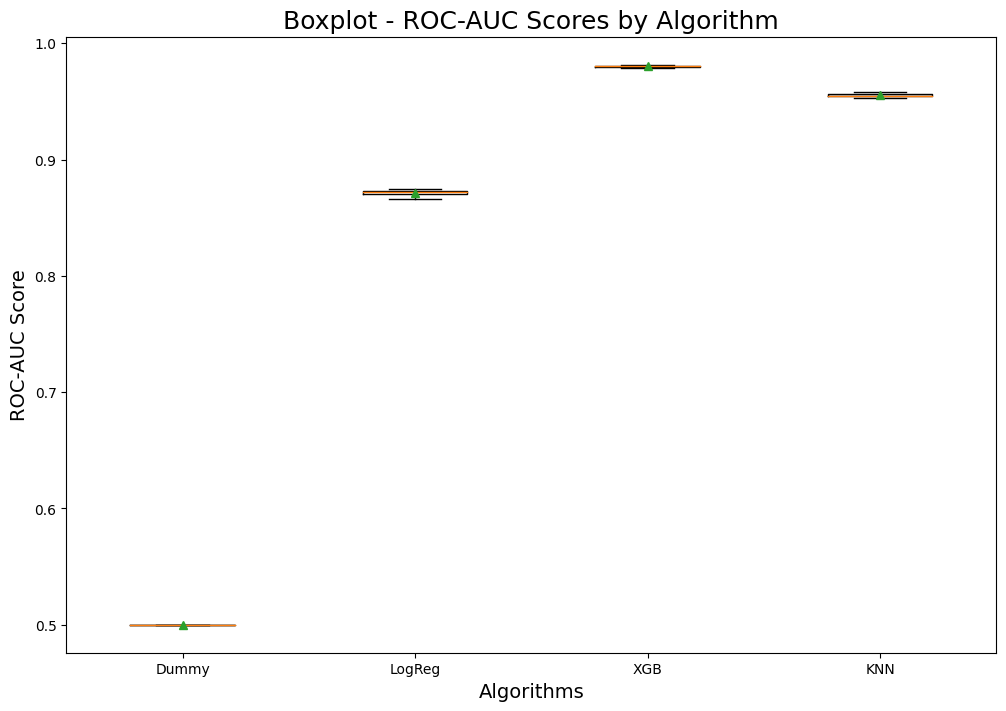

In [24]:
# Prepare plot inputs
names = []
f1 = []
roc_auc = []

for k, v in results.items():
    names.append(k)
    f1.append(v['test_f1'])
    roc_auc.append(v['test_roc_auc'])
    
# F1 scores    
fig = plt.figure(figsize=(12, 8))
plt.boxplot(f1, labels=names, showmeans=True)
plt.title("Boxplot - F1 Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
print("")
plt.show();

# ROC-AUC scores
fig = plt.figure(figsize=(12, 8))
plt.boxplot(roc_auc, labels=names, showmeans=True)
plt.title("Boxplot - ROC-AUC Scores by Algorithm", fontsize=18)
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel("ROC-AUC Score", fontsize=14)
print("" * 2)
plt.show();

## Train XGBoost Model

In [27]:
clf = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(n_estimators=1000))
])
    
# Evaluate model
scores = evaluate_model(X_res, y_res, clf)
results[k] = scores
name = k
print(f"{name}\n{'-' * len(name)}")
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
print('Mean Recall: %.3f (%.3f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
print('Test Precision: %.3f (%.3f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

KNN
---
Mean Accuracy: 0.929 (0.002)
Mean F1: 0.930 (0.002)
Mean Recall: 0.942 (0.002)
Test Precision: 0.917 (0.002)
Mean ROC-AUC: 0.980 (0.001)



In [28]:
filename = "../models/saved_model.pkl"
pickle.dump(clf, open(filename, 'wb'))

## Predict on Test Data

In [29]:
test = pd.read_csv("../data/featurised/featurised_test.csv")

In [ ]:
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores['test_accuracy']), std(scores['test_accuracy'])))
print('Mean F1: %.3f (%.3f)' % (mean(scores['test_f1']), std(scores['test_f1'])))
print('Mean Recall: %.3f (%.3f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
print('Test Precision: %.3f (%.3f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
print('Mean ROC-AUC: %.3f (%.3f)\n' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))

In [ ]:
clf = XGBClassifier(n_estimators=100)
clf.fit(X_res, y=y_res)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))